In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from networkx.algorithms import bipartite

In [6]:
class Matching(dict):
    def __init__(self, G: nx.Graph, describe: bool = False):
        """Determine a maximam matching from the given bipartite graph `G`.
            G:nx.Graph, the graph from which to determine the matching.
            describe:bool, whetever to explain steps or not.
        """
        self._G, self.describe = G.copy(), describe

        if describe:
            self._setup_descriptive()
            self._describe_start()
        for node in G.node:
            if self._is_exposed(node):
                match = self._search(node)
                if match >= 0:
                    self[match] = node
                    if describe:
                        self._describe_add(match, node)
                else:
                    self._G.remove_node(node)
                    if describe:
                        self._describe_remove(node)
        if describe:
            self._describe_result(G)

    def _setup_descriptive(self):
        self._pos = nx.kamada_kawai_layout(self._G)
        positions = np.array(list(self._pos.values()))
        self._min_x, self._min_y = np.min(positions, axis=0) - 0.1
        self._max_x, self._max_y = np.max(positions, axis=0) + 0.1

    def _alternate_colors(self, n):
        return ['r' if i % 2 else 'c' for i in range(n)]

    def _plot_path(self):
        G = nx.Graph(list(self._path.items()))
        node_colors = [
            "c" if self._G.nodes[i]["bipartite"] else "r" for i in G.nodes
        ]
        self._plot_graphs([(
            G,
            node_colors,
        )])

    def _plot_matching(self):
        node_colors = [
            "c" if value["bipartite"] else "r"
            for value in self._G.nodes.values()
        ]
        G = nx.Graph(list(self.items()))
        matching_node_colors = [
            "c" if self._G.nodes[i]["bipartite"] else "r" for i in G.nodes
        ]
        self._plot_graphs([(
            self._G,
            node_colors,
        ), (
            G,
            matching_node_colors,
        )])

    def _plot_graphs(self, graphs: list):
        n = len(graphs)
        w = 4
        plt.figure(figsize=(w * n, w))
        for i, (G, node_colors) in enumerate(graphs):
            plt.subplot(1, n, i + 1)
            plt.xlim(self._min_x, self._max_x)
            plt.ylim(self._min_y, self._max_y)
            nx.draw(G, pos=self._pos, with_labels=True, node_color=node_colors)
        plt.show()

    def _describe_result(self, G: nx.Graph):
        print("Process finished")

    def _describe_start(self):
        print("Starting with empty matching.")
        self._plot_matching()

    def _describe_add(self, match: int, node: int):
        print("Adding match {match}:{node}".format(match=match, node=node))
        print(self)
        self._plot_matching()

    def _describe_remove(self, node: int):
        print("Removing {node}".format(node=node))
        self._plot_matching()

    def _describe_path(self):
        print("Identified augmenting path {path}".format(path=self._path))
        self._plot_path()

    def _is_exposed(self, node: int) -> bool:
        """Return a boolean representing if the given `node` is exposed.
            node:int, the node to check for.
        """
        return not self._is_in_matching(node)

    def _is_in_matching(self, node: int) -> bool:
        """Return a boolean representing if the given node is in the matching.
            node:int, the node to check for.
        """
        return node in self or node in self.values()

    def _get_match(self, node: int) -> int:
        """Return the match for a given node.
            node:int, the node to retrieve a matching for.
        """
        if node in self:
            return self[node]
        for k, v in self.items():
            if v == node:
                return k
        raise ValueError("Given node {node} has no match.".format(node=node))

    def _is_even(self, node: int) -> bool:
        """Return a boolean representing if the given node is labeled as `EVEN`.
            node:int, the node to check parity for.
        """
        return self._labels[node]

    def _is_odd(self, node: int) -> bool:
        """Return a boolean representing if the given node is labeled as `ODD`.
            node:int, the node to check parity for.
        """
        return not self._is_even(node)

    def _is_unlabeled(self, node: int) -> bool:
        """Return a boolean representing if the given node isn't labeled.
            node:int, the node to check labeling for.
        """
        return node not in self._labels

    def _set_node_parity(self, node: int, parity: bool):
        """Set a given node with a given parity label.
            node:int, the node to set to a given parity.
            parity:bool, the value of parity to set it to.
        """
        self._labels[node] = parity

    def _set_even(self, node: int):
        """Set a given node to `EVEN`.
            node:int, the node to set to `EVEN`
        """
        self._set_node_parity(node, True)

    def _set_odd(self, node: int):
        """Set a given node to `ODD`.
            node:int, the node to set to `ODD`
        """
        self._set_node_parity(node, False)

    def _prepend_node(self, node: int):
        """Prepend given `node` to `nodes` list.
            node:int, the node to add to list.
        """
        self._nodes.insert(0, node)
        #self._nodes.append(node)

    def _pop_node(self) -> int:
        """Return first node in nodes list."""
        return self._nodes.pop()

    def _add_step(self, a: int, b: int):
        """Add node to augmenting path."""
        self._path[a] = b

    def _reset(self):
        """Reset `labels` dictionary and `nodes` list to a clean state."""
        self._labels, self._nodes, self._path = {}, [], {}

    def _search(self, current: int) -> int:
        """Return, if found, the starting node of an augmenting path ending in given `current` node. Otherwise `-1`.
            current:int, the node from which the search will start.
        """
        self._reset()
        self._set_even(current)
        self._prepend_node(current)
        if self.describe:
            print("Searching path from {current}.".format(current=current))
        match = -1
        while self._nodes:
            node = self._pop_node()
            if self._is_even(node):
                match = self._search_even(node)
            else:
                self._search_odd(node)
            if match >= 0:
                if self.describe:
                    self._describe_path()
                return match
        return -1

    def _search_even(self, vertex: int):
        """Return, if found, the end of the augmenting path otherwise determines the even odd in the path.
            vertex:int, the even node in the current augmenting path.
        """
        for node in self._G.neighbors(vertex):
            if self._is_exposed(node):
                if self.describe:
                    print("Adding even {node}->{vertex} to path.".format(
                        node=node, vertex=vertex))
                self._add_step(vertex, node)
                return node
            if self._is_in_matching(node) and self._is_unlabeled(node):
                if self.describe:
                    print("Adding even {node}->{vertex} to path.".format(
                        node=node, vertex=vertex))
                self._set_odd(node)
                self._add_step(vertex, node)
                self._prepend_node(node)
        return -1

    def _search_odd(self, vertex: int):
        """Determine the odd step in the augmenting path.
            vertex:int, the odd node in the current augmenting path.
        """
        node = self._get_match(vertex)
        if self._is_unlabeled(node):
            if self.describe:
                print("Adding odd {node}->{vertex} to path.".format(
                    node=node, vertex=vertex))
            self._set_even(node)
            self._add_step(vertex, node)
            self._prepend_node(node)

In [3]:
G = bipartite.random_graph(5, 5, 0.4)

Starting with empty matching.


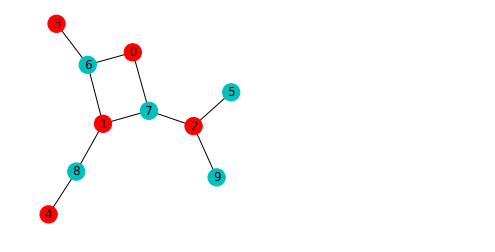

Searching path from 0.
Adding even 6->0 to path.
Identified augmenting path {0: 6}


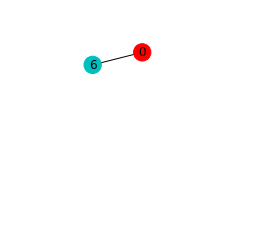

Adding match 6:0
{6: 0}


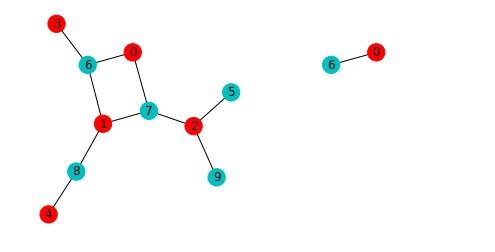

Searching path from 1.
Adding even 6->1 to path.
Adding even 7->1 to path.
Identified augmenting path {1: 7}


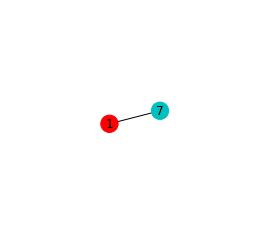

Adding match 7:1
{6: 0, 7: 1}


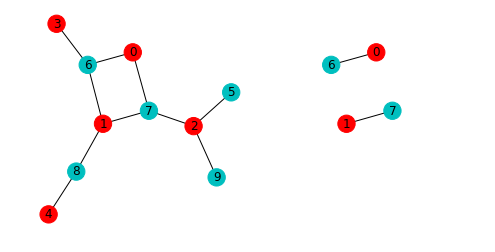

Searching path from 2.
Adding even 5->2 to path.
Identified augmenting path {2: 5}


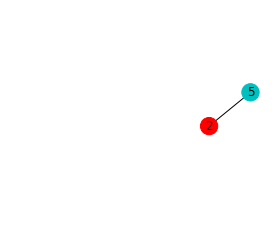

Adding match 5:2
{6: 0, 7: 1, 5: 2}


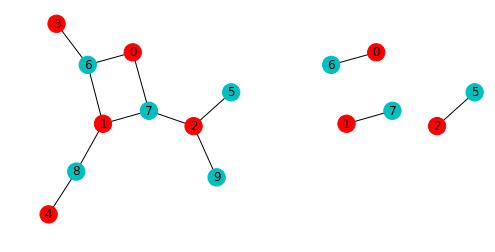

Searching path from 3.
Adding even 6->3 to path.
Adding odd 0->6 to path.
Adding even 7->0 to path.
Adding odd 1->7 to path.
Adding even 8->1 to path.
Identified augmenting path {3: 6, 6: 0, 0: 7, 7: 1, 1: 8}


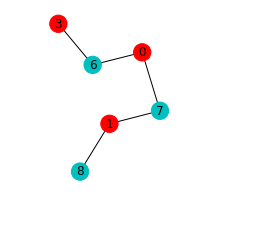

Adding match 8:3
{6: 0, 7: 1, 5: 2, 8: 3}


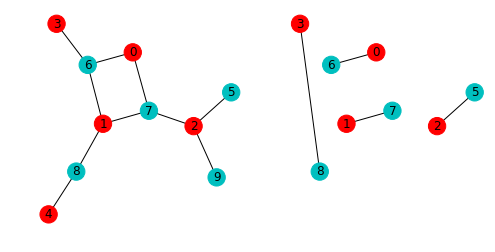

Searching path from 4.
Adding even 8->4 to path.
Adding odd 3->8 to path.
Adding even 6->3 to path.
Adding odd 0->6 to path.
Adding even 7->0 to path.
Adding odd 1->7 to path.
Removing 4


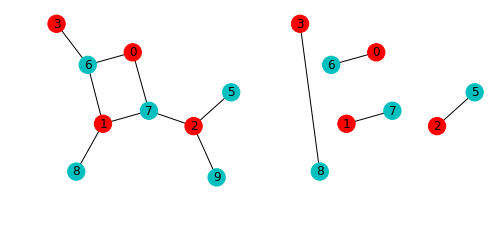

Searching path from 9.
Adding even 2->9 to path.
Adding odd 5->2 to path.
Removing 9


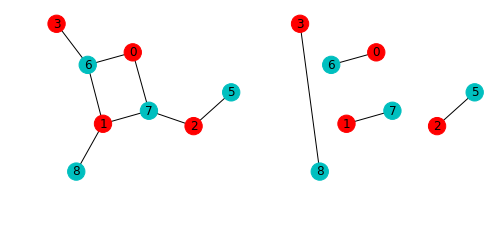

Process finished


In [7]:
M = Matching(G, describe=True)